In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import json
import os

In [2]:
# scores:
    # 'Precision', 'Recall', 'F1', 'Average Changed Cell Count', 'Average Generated Instruction Length', 'Average Generated Expression Number of Tokens'
    # F1 = Bench score
# invalid format: either "Invalid grid format" or 'Invalid instruction format'

In [3]:
top_level_directories: list = ['v0.9', 'v1.0', 'v1.5', 'v1.5_quantized', 'v1.6', 'v1.6_backends', 'v1.6_quantized']
game: str = 'imagegame'
game_variants: list = ['0_compact_grids', '1_random_grids']

In [4]:
# Store general information about the amount of episodes and how they ended
episodes: dict = {
    'available_episodes': 0,
    '0_compact_grids': {
        'total_episodes': 0,
        'correct guess': 0,
        'invalid format': 0,
        'Invalid grid format':0,
        'Invalid instruction format':0, 
        'Instruction: DONE': 0, 
        'max turns reached': 0,
        'invalid clue': 0,
        'get message': 0,
        'parse': 0, 
    },
    '1_random_grids': {
        'total_episodes': 0,
        'correct guess': 0,
        'invalid format': 0,
        'Invalid grid format':0,
        'Invalid instruction format':0,
        'Instruction: DONE': 0, 
        'max turns reached': 0,
        'invalid clue': 0,
        'get message': 0,
        'parse': 0,
    }
}

# collect information about the different game domains
unique_game_domains: dict = {}

# collect information in dataframe format
df_dict: dict = {
    'benchmark_version': [],
    'model_id': [],
    'difficulty': [],
    'number_of_turns': [],
    'end_of_game_type': [],
    'episode_number': [],
}

for top_level_directory in top_level_directories:
    # loop over all directories with all variants of the benchmark
    all_available_models: list = os.listdir(f'./{top_level_directory}')
    # filter all files that are not a directory
    all_available_models = [model_name for model_name in all_available_models if os.path.isdir(f'./{top_level_directory}/{model_name}')]
    for model_name in all_available_models:
        # for each model pick all episodes from the taboo game folder
        for game_variant in game_variants:
            all_episodes: list =  os.listdir(f'./{top_level_directory}/{model_name}/{game}/{game_variant}')
            # filter all file names that do not start with episode to ensure to not read files without episodes
            all_episodes = [episode for episode in all_episodes if episode.startswith('episode')]
            
            # count the number of all episodes
            episodes['available_episodes'] += len(all_episodes)
            # count the number of episodes of a particular game variant
            episodes[game_variant]['total_episodes'] += len(all_episodes)
            
            # loop over all episodes to check whether an episode ended with success or any problems
            for episode in all_episodes:
                path_interactions: str = f'./{top_level_directory}/{model_name}/{game}/{game_variant}/{episode}/interactions.json'
                path_instances: str = f'./{top_level_directory}/{model_name}/{game}/{game_variant}/{episode}/instance.json'

                if os.path.isfile(path_interactions) and os.path.isfile(path_instances):
                    # open the interaction.json file to read all interactions
                    with open(path_interactions,  encoding="utf8") as json_file:
                        interactions: dict = json.load(json_file)
                        
                        # get the last turn of the interaction
                        last_turn: list = interactions['turns'][-1]
                        
                        # get game ending 
                        game_ending: str = last_turn[-1]['action']['type']
                        if game_ending == 'invalid format':
                            game_ending: str = last_turn[-1]['action']['content']
                        
                        # add game ending
                        episodes[game_variant][game_ending] += 1

                        # add information to df_dict
                        df_dict['benchmark_version'].append(top_level_directory)
                        df_dict['model_id'].append(model_name)
                        df_dict['difficulty'].append(game_variant)
                        df_dict['number_of_turns'].append(len(interactions['turns']))
                        df_dict['end_of_game_type'].append(game_ending)
                        df_dict['episode_number'].append(episode)

                    # open the instance.json file to collect information about the domain of the game
                    #instance_data: DataFrame = pd.read_json(path_instances)
                    #target_word: str = instance_data.target_word.iloc[0]

                    #df_dict['target_word'].append(target_word)

In [5]:
data_df: DataFrame = DataFrame(data=df_dict)
data_df

,benchmark_version,model_id,difficulty,number_of_turns,end_of_game_type,episode_number
0,v0.9,luminous-supreme-t0.0--luminous-supreme-t0.0,0_compact_grids,1,Invalid instruction format,episode_5
1,v0.9,luminous-supreme-t0.0--luminous-supreme-t0.0,0_compact_grids,1,Invalid instruction format,episode_2
2,v0.9,luminous-supreme-t0.0--luminous-supreme-t0.0,0_compact_grids,1,Invalid instruction format,episode_3
3,v0.9,luminous-supreme-t0.0--luminous-supreme-t0.0,0_compact_grids,1,Invalid instruction format,episode_4
4,v0.9,luminous-supreme-t0.0--luminous-supreme-t0.0,0_compact_grids,1,Invalid instruction format,episode_14
...,...,...,...,...,...,...
6595,v1.6_quantized,Meta-Llama-3-70B-Instruct-GGUF-q8-t0.0--Meta-L...,1_random_grids,1,Invalid instruction format,episode_10
6596,v1.6_quantized,Meta-Llama-3-70B-Instruct-GGUF-q8-t0.0--Meta-L...,1_random_grids,1,Invalid instruction format,episode_17
6597,v1.6_quantized,Meta-Llama-3-70B-Instruct-GGUF-q8-t0.0--Meta-L...,1_random_grids,1,Invalid instruction format,episode_16
6598,v1.6_quantized,Meta-Llama-3-70B-Instruct-GGUF-q8-t0.0--Meta-L...,1_random_grids,1,Invalid instruction format,episode_11


In [6]:
data_df.end_of_game_type.value_counts()

end_of_game_type
Invalid instruction format    4207
Invalid grid format           1385
get message                    989
parse                           19
Name: count, dtype: int64

There are 6658 total turns


<Axes: ylabel='Frequency'>

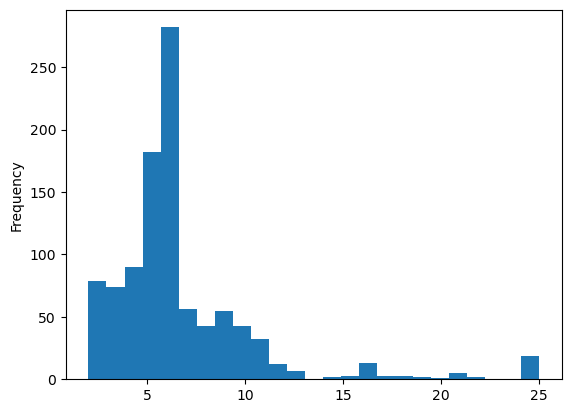

In [7]:
successes = data_df.query('end_of_game_type == "get message" or end_of_game_type == "parse"')
print(f"There are {sum(successes.number_of_turns)} total turns")
successes.number_of_turns.plot.hist(bins = 25)